# <center>**Hierarchical spline for time series forecasting:<br>An application to Naval ship engine failure rate**</center>
## <center>Hyunji Moon, Jinwoo Choi, Hyeonseop Lee</center>

<center>Department of Industrial Engineering, Seoul National University, mhj1667@gmail.com </center>

<center>Ph.D. Candidate, Defense Management, Korea National Defense University, chlwlsdn8570@gmail.com</center>

<center>Department of Computer Science, Korea Advanced Institute of Science and Technology, hyeonseop@kaist.ac.kr</center>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
from pystan import StanModel
from scipy.interpolate import splev
from fbprophet import Prophet
import pmdarima as pm
import itertools
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


# Abstract

Predicting equipment failure is important because it could improve availability and cut down operating budget. Previous literatures have attempted to model failure rate with bathtub-formed function, weibull distribution, Bayesian network, or AHP. But these models perform well with sufficient amount of data and could not incorporate the two salient characteristics; unbalanced category and sharing structure. Hierarchical model has the advantage of partial pooling. The proposed model is based on Bayesian hierarchical B-spline. Time series of failure rate of 99 ROK Naval ships have been modeled as hierarchical model, where each layer corresponds to ship engine, Engine type, and Engine archetype. As a result of analysis, the suggested model predicted the failure rate of an entire life time accurately in multiple situational conditions.

Keywords: Failure rate; Hierarchical model; B-Spline; Stan; Time series forecasting; Naval ships data

# Introduction

Forecasting faliure rate is important as it serves as a standard for preventive measure, inventory management. Both over and underestimation of failure are detrimental to the system. Underestimation can lead to mission failure due to failure, overestimation can lead to wasted budget and reduced operational efficiency due to excessive spare part purchases. Therefore taking account of features of failure data into the model is important. Two characteristics of failure rate data, unbalanced category and sharing structure, are the main motivation for this paper and we propose hierarchical spline model for improvement. Firstly, unbalanced category refers to the fact that collected data corresponding to each age are unbalanced for each category; product type, for example. Secondly, is sharing structure. In our case of predicting the failure rate of an engine of each ship, as engines are shared among ships, ships with the same type of engine display similar failure rate pattern. The underlying process also supports the empirical results, as same engines types share design pattern and made from the same factory.

Hierarchical model provides systemic structure to improve both unbalanced category and sharing characteristic of data. In our problem setting, even the failure rate of an age period where data of a certain ship engine is unavailble could be forecasted as paramters could be borrowed from other types of ships and engines. For this purpose, we have construced our three layer model as the following: a root layer that accounts for the core characteristics of an engine, i.e. engine archetype, a second layer which corresponds to each type of an engine, and lastly, the final layer that explains the specific characteristics of each ship.

The proposed model has additional advantages in terms of forecasting the failure of new engine types. ROK Navy battle ship evlove continuously; for example, FF (Fate Frigate) class have been replaced by FFG (Fast Frigate Guided-missile). Forecasting the failure rates of a new battle ship is clueless, but necessary. Most existing time series models such as ARIMA or ETS(exponential smoothing) model struggles in situation where no quantitative data exist. However, in hierachical model it is possible to constuct the outline of the failure function based on the prior qualitative information. For instance, engines constructed in similar era show similar patterns. Therefore, information on which era the unforeseen engine was made could be utilized to forecast its failure rates.

The main contribution of this paper lies in applying hierarchical spline(HS) model to address unbalanced category and sharing structure of failure data from ROK Navy. Compared to the previous models, proposed model not only improves overall forecast accuracy but also is capable of forecasting failure rates for categories with scarce data robustly. Moreover, the hypothetical similarity between each category, can be tested and proved using our model; this enables use to utilize the qualitative knowledge on the unforeseen, ships with new engines for example, for forecasting. These results, when used as a reference for maintenance policy and budget allocation, could contribute greatly to the Navy's operataion system. However, this model is not limited to Naval domain. When in comes to forecasting failure rates, the circumstances where data are hierarchical, unbalanced, or insufficient are common and therefore, our model is widely applicable.

# Data

In [2]:
failure_df = pd.read_csv('failure_count.csv').set_index('age')
u = np.nanmean(failure_df.values.flatten())
s = np.sqrt(np.nanvar(failure_df.values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
engine_df = pd.read_csv('engine.csv').set_index('ship')

test_failure_df = pd.read_csv('failure_count_test.csv').set_index('age')
test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv('engine_test.csv').set_index('ship')

Dataset consists of 99 ship engines that could be catagorized with five types of engines. 7, 26, 43, 19,  4 ships belong to each engine type. Therefore, our
hierarchical model has 1-5-99 structure; 1 engine archetype, 5 engine types, and 99 ship types. The numbers of ships in the five categories are also different.

The figure below shows the age, type of engine and ship of existing data. As can be seen from the figure, amount of data for each category is highly unbalanced. Moreover, similarity between data under the same category could be inferred; for example, data with the same type of engine display simliar age period.

By arranging the failure data of 99 propulsion ship engine categorized into 5 types according to their lifetimes, we got the failure rate data for the approximate total life cycle of 31 years (It is expressed as approximate because it is not based on the total life data of each ship, but is the data of the total life created by combining parts).

The data only include maintenance records from the military direct maintenance workshop. After the construction, the initial repair of the shipyard(warranty repair) was not included in the data. Also, data may not be entered into the management system for other reasons. Therefore, it can be said that the failure data of the part corresponding to the initial part after constructing is reflected less than actual.

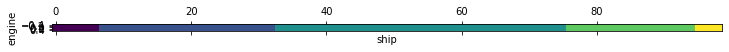

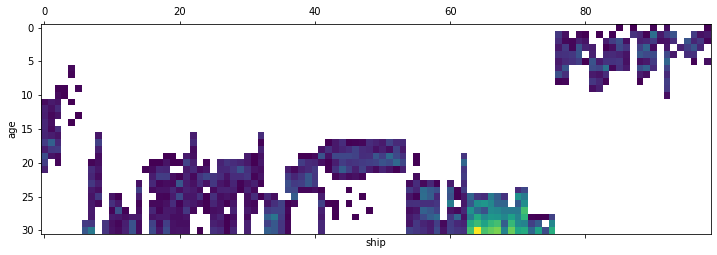

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('ship')
ax.set_ylabel('engine')
ax.matshow(engine_df.transpose())
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('ship')
ax.set_ylabel('age')
ax.matshow(failure_df)
plt.show()

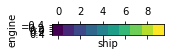

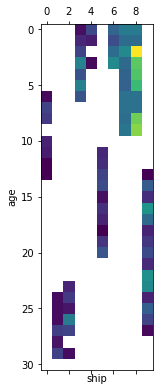

In [4]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_xlabel('ship')
ax.set_ylabel('engine')
ax.matshow(test_engine_df.transpose())
plt.show()

fig, ax = plt.subplots(figsize=(2, 8))
ax.set_xlabel('ship')
ax.set_ylabel('age')
ax.matshow(test_failure_df)
plt.show()

# Model

Proposed naval ship engine model is comprised of three layers. The ship engine (layer 3) of
each ship belongs to the same engine type (layer 2), and 5 engine types belongs to the entire engine archetype (layer 1).

Since the naval ship data is nonlinear time series data, polynomial and spline regression are considered. In polynomial regression, to achieve flexibility, degree should be increased; however, the risk of overfit becomes higher with its degree. To prevent this and to endow the model a form of locality, B-Spline model is suggested: overall life span, or age period, are first divided into several sections. Then low-dimensional polynimial is fitted for each section to form a piecewise polynomial spline.

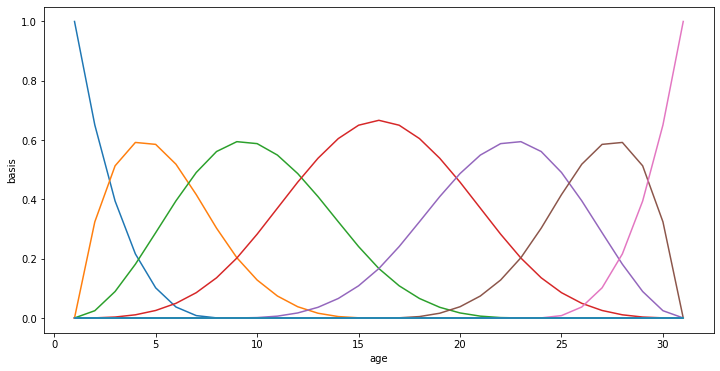

In [5]:
degree = 3
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

The third layer of ROK naval ship hierachy, representing ship engine, is modeled with B-Spline. As can be seen from equations below, parameters corresponding to each layer are modeled in a way that could enable the pooling possible; through hyperparameter sharing strucutres.

$Y_s \sim Normal(\mu_s, \sigma_y)$

$\mu_s = a_s + \sum\limits_{k=1}^{K}w_{k,s} B_k$

$\alpha_s \sim Normal(\bar{\alpha_e}, \sigma_\alpha)$

$w_s \sim Normal(\bar{w_e}, \sigma_w)$

$\bar{\alpha_e} \sim Normal(\bar{\alpha_0}, \sigma_\bar{\alpha})$

$\bar{w_e} \sim Normal(\bar{w_0}, \sigma_\bar{w})$

$\sigma_\alpha \sim Gamma(10, 10)$

$\sigma_w \sim Gamma(10, 10)$

$\sigma_\bar{\alpha} \sim Exponential(1)$

$\sigma_\bar{w} \sim Exponential(1)$

$\sigma_y \sim Exponential(1)$

$\bar{\alpha_0} \sim Normal(1, 1)$

$\bar{w_0} \sim Normal(0, 1)$

Modeled using Stan. Stan has the advantage of faster estimation of bayesian models in ecology in mcmc. Stan HMC is effective as model complexity is large and correlated variables are large. Stan was used in consideration of future developments (complexity and variables to be added) of the proposed model.

In [6]:
model_code ='''
data {
    int<lower=1> K; // number of knots
    int<lower=1> N; // number of datapoints
    int<lower=1> T; // maximum age
    int<lower=1> S; // number of ships
    int<lower=1> E; // number of engines
    int<lower=1> age[N];
    int<lower=1> ship[N];
    int<lower=1> engine[S];
    matrix[T,K] B;
    vector[N] Y;
}

parameters {
    // first layer
    real mu_alpha_bar;
    real<lower=0> sigma_alpha_bar;
    vector[K] mu_w_bar;
    real<lower=0> sigma_w_bar;

    // second layer
    real alpha_bar[E];
    real<lower=0> sigma_alpha;
    vector[K] w_bar[E];
    real<lower=0> sigma_w;

    // third layer
    real alpha[S];
    vector[K] w[S];
    real<lower=0> sigma_y;
}

transformed parameters { 
    vector[N] mu;
    for (n in 1:N) {
        mu[n] = alpha[ship[n]] + B[age[n]] * w[ship[n]];
    }
}

model {
    mu_alpha_bar ~ normal(0, 1);
    mu_w_bar ~ normal(0, 1);
    sigma_alpha_bar ~ exponential(1);
    sigma_w_bar ~ exponential(1);

    for (e in 1:E) {
        alpha_bar[e] ~ normal(mu_alpha_bar, sigma_alpha_bar);
        w_bar[e] ~ normal(mu_w_bar, sigma_w_bar);
    }
    sigma_alpha ~ gamma(10,10);
    sigma_w ~ gamma(10,10);

    for (s in 1:S) {
        alpha[s] ~ normal(alpha_bar[engine[s]], sigma_alpha);
        w[s] ~ normal(w_bar[engine[s]], sigma_w);
    }
    sigma_y ~ exponential(1);
    
    Y ~ normal(mu, sigma_y);
}

generated quantities{
    vector[N] log_likelihood;
    for (n in 1:N) {
        log_likelihood[n] = normal_lpdf(Y[n]|mu[n], sigma_y);
    }
}
'''

In [7]:
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a59580e5db61f955d823bf8726e6e031 NOW.


# Training

Perform sampling and take posterior mean for each paremeters.

In [8]:
K = basis_df.shape[1]
T = 31
S = failure_df.shape[1]
E = np.unique(engine_df['engine']).shape[0]
Y = failure_df.values[~failure_df.isnull()]
age_index, ship_index = np.where(~failure_df.isnull())

data = {
    'K' : K,
    'N' : Y.shape[0],
    'T' : T,
    'S' : S,
    'E' : E,
    'age': age_index + 1,
    'ship': ship_index + 1,
    'engine': engine_df.loc[failure_df.columns, 'engine'],
    'Y': Y,
    'B': basis_df,
}

fit = sm.sampling(data=data)
fit_df = fit.to_dataframe().mean()

samples = fit.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
K = basis_df.shape[1]
T = 31
S = failure_df.shape[1]
E = np.unique(engine_df['engine']).shape[0]
Y = failure_df.values[~failure_df.isnull()]
age_index, ship_index = np.where(~failure_df.isnull())

data = {
    'K' : K,
    'N' : Y.shape[0],
    'T' : T,
    'S' : S,
    'E' : E,
    'age': age_index + 1,
    'ship': ship_index + 1,
    'engine': engine_df.loc[failure_df.columns, 'engine'],
    'Y': Y,
    'B': basis_df,
}

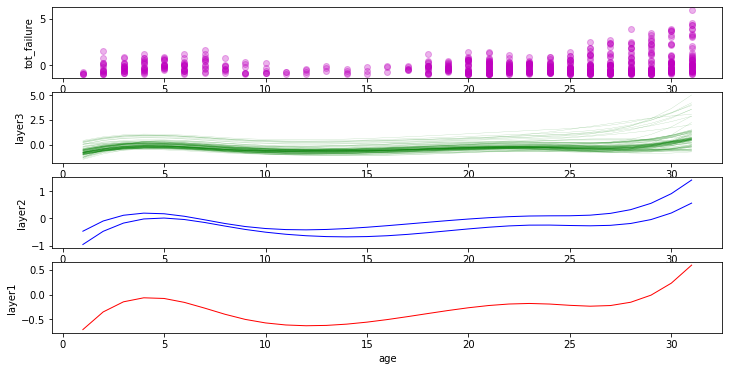

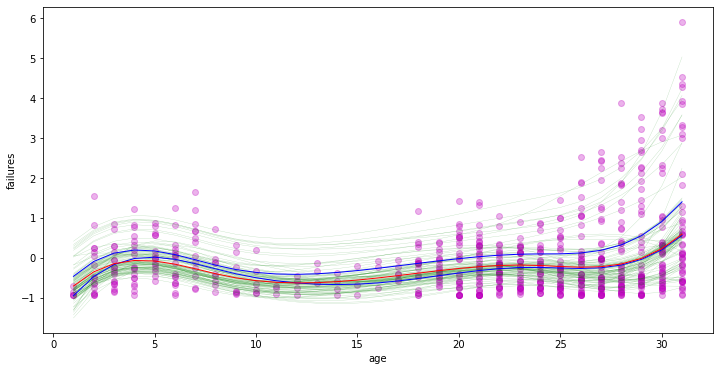

In [10]:
alpha = np.array([fit_df[f'alpha[{s+1}]'] for s in range(S)])
w = np.array([[fit_df[f'w[{s+1},{k+1}]'] for k in range(K)] for s in range(S)])
mu = np.tile(np.expand_dims(alpha, 0), (T, 1)) + basis_df.values @ w.transpose()

alpha_bar = np.array([fit_df[f'alpha_bar[{e+1}]'] for e in range(E)])
w_bar = np.array([[fit_df[f'w_bar[{e+1},{k+1}]'] for k in range(K)] for e in range(E)])
mu_bar = np.tile(np.expand_dims(alpha_bar, 0), (T, 1)) + basis_df.values @ w_bar.transpose()

mu_alpha_bar = fit_df['mu_alpha_bar']
mu_w_bar = np.array([fit_df[f'mu_w_bar[{k+1}]'] for k in range(K)])
mu_zero = np.repeat(mu_alpha_bar, failure_df.shape[0]) + basis_df.values @ mu_w_bar

fig, axes = plt.subplots(4,1,figsize=(12, 6))
for i in range(4):
    axes[i].set_xlabel('age')
    if i == 0: axes[i].set_ylabel('tot_failure')
    else: axes[i].set_ylabel(f'layer{4-i}')
axes[0].scatter(failure_df.index[age_index], Y, color='m', alpha=0.3)
axes[1].plot(np.arange(1, T + 1), mu, color='g', alpha=0.3, linewidth=0.3)
axes[2].plot(np.arange(1, T + 1), mu_bar[:,(2,3)], color='b', alpha=1, linewidth=1)
axes[3].plot(np.arange(1, T + 1), mu_zero, color='r', alpha=1, linewidth=1)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('failures')
ax.scatter(failure_df.index[age_index], Y, color='m', alpha=0.3)
ax.plot(np.arange(1, T + 1), mu, color='g', alpha=0.3, linewidth=0.3)
ax.plot(np.arange(1, T + 1), mu_bar[:,(2,3)], color='b', alpha=1, linewidth=1)
ax.plot(np.arange(1, T + 1), mu_zero, color='r', alpha=1, linewidth=1)
plt.show()

Also Prophet and ARIMA model are trained for evaluation.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

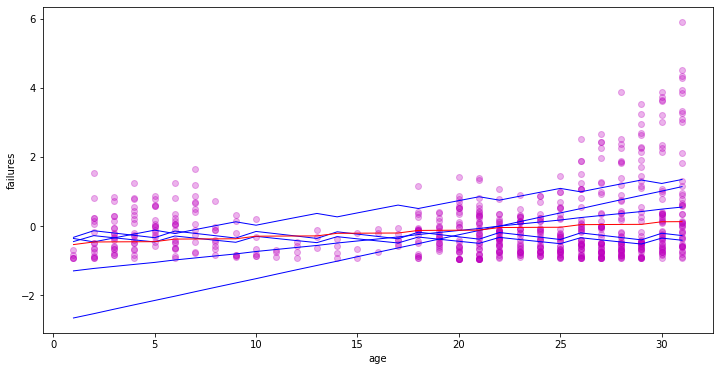

In [11]:
def predict_prophet(s):
    ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
    training_df = pd.DataFrame({'ds': ds, 'y': s})
    m = Prophet()
    m.fit(training_df)
    predict_df = pd.DataFrame({'ds': ds})
    return m.predict(predict_df)['yhat']

y_bar_prophet = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
y_bar_prophet = np.array(y_bar_prophet).transpose()

y_zero_prophet = predict_prophet(failure_df.mean(axis=1).values)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('failures')
ax.scatter(failure_df.index[age_index], Y, color='m', alpha=0.3)
ax.plot(np.arange(1, T + 1), y_bar_prophet, color='b', alpha=1, linewidth=1)
ax.plot(np.arange(1, T + 1), y_zero_prophet, color='r', alpha=1, linewidth=1)
plt.show()

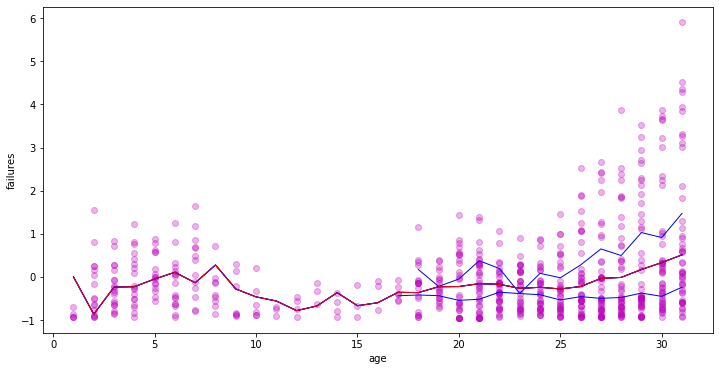

In [12]:
def predict_arima(s):
    pn = len(list(itertools.takewhile(np.isnan, s)))
    tn = len(list(itertools.takewhile(np.isnan, s[::-1])))
    if tn:
        m = pm.auto_arima(s[pn:-tn])
        return np.concatenate(
            (np.full(pn, np.nan)),
            m.predict_in_sample(),
            m.predict(tn),
        )
    else:
        m = pm.auto_arima(s[pn:])
        return np.concatenate((
            np.full(pn, np.nan),
            m.predict_in_sample(),
        ))

y_zero_arima = predict_arima(failure_df.mean(axis=1).values)

y_bar_arima = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    try:
        y_bar_arima.append(predict_arima(failure_df[ships].mean(axis=1).values))
    except:
        y_bar_arima.append(y_zero_arima)
y_bar_arima = np.array(y_bar_arima).transpose()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('failures')
ax.scatter(failure_df.index[age_index], Y, color='m', alpha=0.3)
ax.plot(np.arange(1, T + 1), y_bar_arima, color='b', alpha=1, linewidth=1)
ax.plot(np.arange(1, T + 1), y_zero_arima, color='r', alpha=1, linewidth=1)
plt.show()

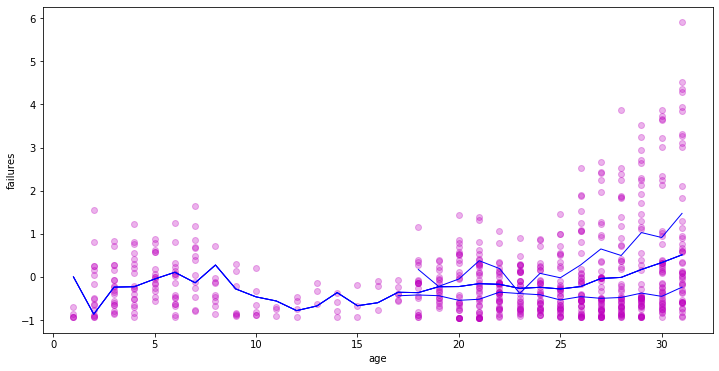

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('failures')
ax.scatter(failure_df.index[age_index], Y, color='m', alpha=0.3)
#ax.plot(np.arange(1, T + 1), mu, color='g', alpha=0.3, linewidth=0.3)
#ax.plot(np.arange(1, T + 1), mu_bar, color='b', alpha=1, linewidth=1)
ax.plot(np.arange(1, T + 1), y_bar_arima, color='b', alpha=1, linewidth=1)
plt.show()

# Evaluation

Forecasting engine failure of a new ship have two scenarios depending on the prior knowledge on its engine type. The first and second equation each represent the situation with existing (1~5 in test_engine_df) and new (6~10 in test_engine_df) engine type. $y_{es}$is failure rate of ship s using engine type e.  

$p(y_{ext, s}|D)=\int p(y_{ext,s}|\theta_{ext})p(\theta_{ext} | D) d\theta_{ext}$

$p(y_{new,s}|D)
=\int p(y_{new, s}|\theta_{new})p(\theta_{new} | D) d\theta_{5}
=\int p(y_{new, s}|\theta_{new})p(\theta_{new} | \eta)p(\eta |D) d\theta_{new}d\eta
$

## Train set

overall error


(0.197675538181526, 0.4853706842598374, 0.5325935040988183)

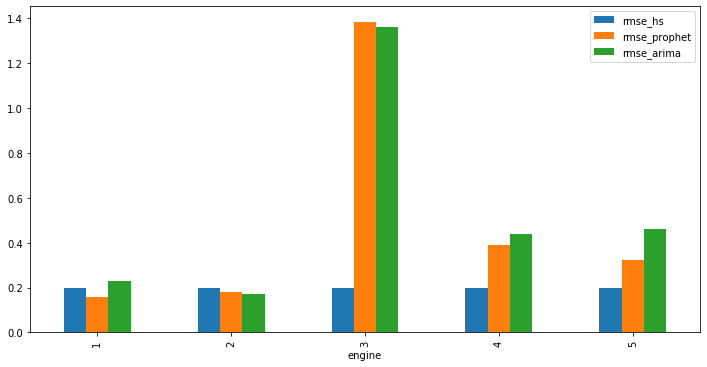

In [20]:
rmse_hs = []
rmse_prophet = []
rmse_arima = []
for e in range(1, 6):
    train_ships = engine_df.index[engine_df['engine'] == e]
    train_Y = failure_df[train_ships].values[~failure_df[train_ships].isnull()] 

    age_index, ship_index = np.where(~failure_df[train_ships].isnull())
    rmse_hs.append(mean_squared_error(train_Y, mu[age_index,ship_index]))
    rmse_prophet.append(mean_squared_error(train_Y, y_bar_prophet[age_index, e - 1]))
    rmse_arima.append(mean_squared_error(train_Y, y_bar_arima[age_index, e - 1]))
rmse_hs = mean_squared_error(Y, mu[~failure_df.isnull()])
fig, ax = plt.subplots(figsize=(12, 6))
pd.DataFrame({'engine': range(1, 6),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}).set_index('engine').plot.bar(ax=ax)
print("overall error")
np.mean(rmse_hs), np.mean(rmse_prophet), np.mean(rmse_arima)

## Forecasting failures of new ship using existing engine type

HS model has the smallest overall error. Errors for each engine type are compared as a plot. Considering each engine type category has 7, 26, 43, 19, 4 ships, improvement of HS are greater for categories with enough data.

overall error


(0.2248544162852517, 0.30161877702190376, 0.23337660412269576)

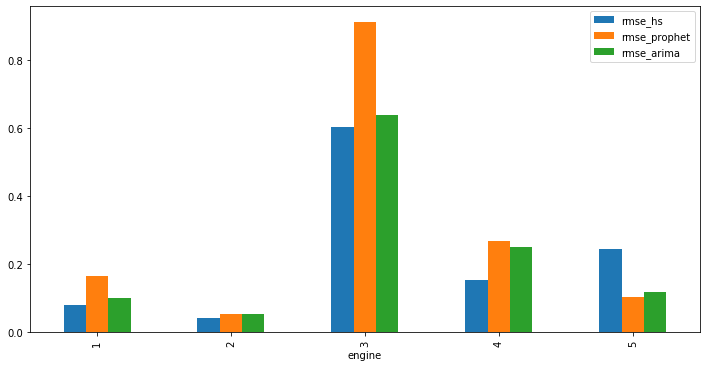

In [15]:
rmse_hs = []
rmse_prophet = []
rmse_arima = []
for e in range(1, 6):
    test_ships = test_engine_df.index[test_engine_df['engine'] == e]
    test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
    test_age_index, test_ship_index = np.where(~test_failure_df[test_ships].isnull())
    rmse_hs.append(mean_squared_error(test_Y, mu_bar[test_age_index, e - 1]))
    rmse_prophet.append(mean_squared_error(test_Y, y_bar_prophet[test_age_index, e - 1]))
    rmse_arima.append(mean_squared_error(test_Y, y_bar_arima[test_age_index, e - 1]))

fig, ax = plt.subplots(figsize=(12, 6))
pd.DataFrame({'engine': range(1, 6),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}).set_index('engine').plot.bar(ax=ax)
print("overall error")
np.mean(rmse_hs), np.mean(rmse_prophet), np.mean(rmse_arima)

## Forecasting failures of new ship using new engine type
Arima has the smallest overall error, but HS could be improved by reflecting the qualitative knowledge.

overall error


(0.9185112786529993, 1.0385134758663663, 0.8539522562247084)

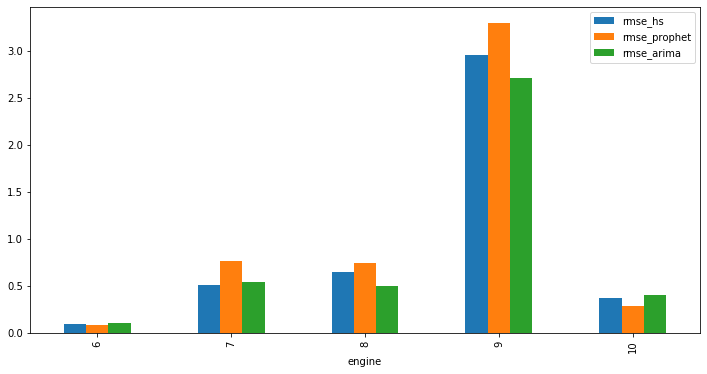

In [16]:
rmse_hs = []
rmse_prophet = []
rmse_arima = []
for e in range(6, 11):
    test_ships = test_engine_df.index[test_engine_df['engine'] == e]
    test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
    test_age_index, test_ship_index = np.where(~test_failure_df[test_ships].isnull())
    rmse_hs.append(mean_squared_error(test_Y, mu_zero[test_age_index]))
    rmse_prophet.append(mean_squared_error(test_Y, y_zero_prophet[test_age_index]))
    rmse_arima.append(mean_squared_error(test_Y, y_zero_arima[test_age_index]))

fig, ax = plt.subplots(figsize=(12, 6))
pd.DataFrame({'engine': range(6, 11),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}).set_index('engine').plot.bar(ax=ax)
print("overall error")
np.mean(rmse_hs), np.mean(rmse_prophet), np.mean(rmse_arima)

## Further: Reflecting the prior information
To improve the model, prior qualitative knowledge of new engine type could be used. In other words, instead of integrating out $\eta$ to get $p(\theta_{new}|D)$, $p(\theta_{new}|D)$ could be expressed as the function of existing $p(\theta_{old}|D)$s. Simplest function being the weighted averge, the equation could be updated as follows:

$p(y_{new,s}|D)
=\int \int p(y_{new, s}|\theta_{new})p(\theta_{new} | \eta)p(\eta |D) d\eta d\theta_{new}
=\int p(y_{new, s}|\theta_{new}) \sum_{e = 1}^{E}w_e \cdot p(\theta_{e} |D) d\theta_{new}
$

Prior information of new type of engine such as engine construction era or series could be used to learn the fuction. This process is justified by the analysis of relationship between the exisiting engine types.

> Prior information on engine type 1~5

> [construction era] 20th century: 2,3 / 21th century: 1,4,5

>[series] series1: 2 -> 5 / series2: 3 -> 4

Following plot and distance calculation verifies that different engine types sharing certain characteristics tend to have similar parameters or patterns. First, failure rate is shifted down due to the technical development. For example, type3 engine takes similar form with type2 engine, the main difference being its intercept. Second, the period of engine design has a big effect on its failure results. Euclidean distance between each function indicates that engine types 1,2,5 which are constructed in 21th century are relatively close. 

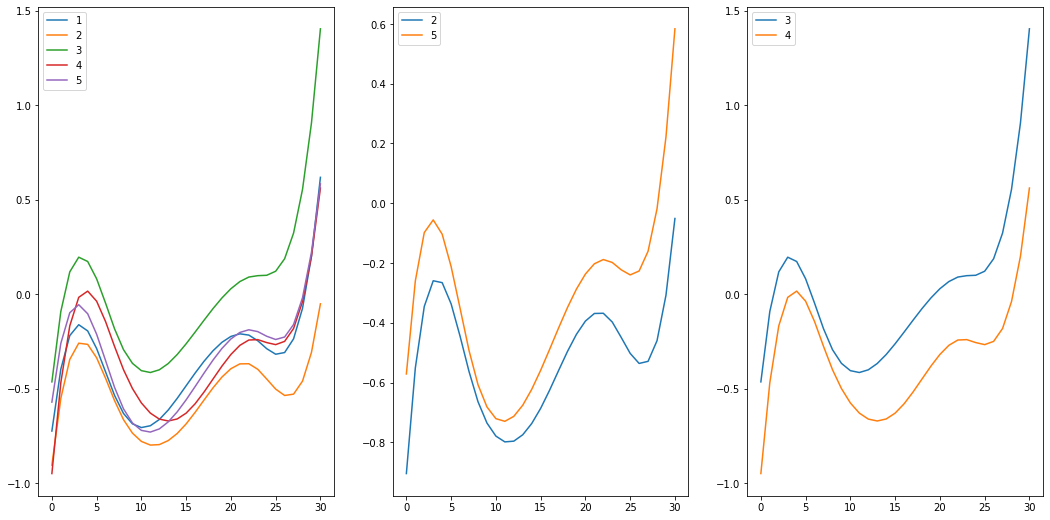

In [17]:
fig, axes = plt.subplots(1,3, figsize = (18, 9))
for i in np.arange(1, 6):
    axes[0].plot(mu_bar.transpose()[i-1], label = i)
    axes[0].legend()
for i in [2,5]:
    axes[1].plot(mu_bar.transpose()[i-1], label = i)
    axes[1].legend()
for i in [3,4]:
    axes[2].plot(mu_bar.transpose()[i-1], label = i)
    axes[2].legend()

In [18]:
def calc_dist(arr):
    dist_l = [((i+1,j+1), euclidean_distances([arr[:,i]], [arr[:,j]])[0][0]) for (i,j) in list(combinations(np.arange(E),2))]
    return [dist_l[i] for i in np.argsort(np.array([i[1] for i in dist_l]))]
calc_dist(mu_bar)

[((1, 5), 0.38716514866876367),
 ((4, 5), 0.7076569719122321),
 ((1, 4), 0.7681838871965471),
 ((1, 2), 1.2414457145308422),
 ((2, 4), 1.358935782276569),
 ((2, 5), 1.3609663551851565),
 ((3, 5), 1.9995090020047002),
 ((3, 4), 2.092539986843391),
 ((1, 3), 2.124924037684366),
 ((2, 3), 3.2914285237749366)]

# Conclusion

We have proposed using HS to develop a hierarchical model for forecasting failure rates. This approach shines especially when the data have unbalanced category and structured characteristic. We demonstrated the applicability of the model using a real-world dataset of failure rate data from Naval ships and compared with previous methods.

The proposed model can contribute greatly to the following areas. First, failure rate prediction could be used as a quantitative reference when establishing a maintenance policy. Proper maintenance not only improves the availability and mission completion rates, but also reduces budget by reducing unnecessary maintenance. Second, in a more broader perspective, predicted failure trend can be a qualitative reference for designing the optimal life cycle of a ship. For instance, based on our results, failure rate increases dramatically as the ship becomes senile. Therefore optimial retirement period could be decided by balancing the maintaince and construction cost.